## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0
sys

'E_reco'

In [4]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    if sys == "Combined":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
    if sys == "BKG":
        
        # piece wise model
        # remove old bkg model
        setup.set_up_bkg_sys_V( breake = 10,
                            index1 = 2,
                            index2 = 1.5, 
                            magnitude = magnitude )
        
        dataset_asimov, dataset_asimov_N = setup.run()
        
        setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
        setup.set_piecewise_bkg_model(dataset_asimov_N)
        # energy of the following parameters smaller than ethrshold
        dataset_asimov_N.background_model.parameters['norm0'].frozen = True
        dataset_asimov_N.background_model.parameters['norm1'].frozen = True
        dataset_asimov_N.background_model.parameters['norm2'].frozen = True
        dataset_asimov_N.background_model.parameters['norm3'].frozen = True
        setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
        frozen_pos = 1
        if frozen_pos:
            dataset_asimov.models.parameters['lon_0'].frozen = True
            dataset_asimov.models.parameters['lat_0'].frozen = True
            dataset_asimov_N.models.parameters['lon_0'].frozen = True
            dataset_asimov_N.models.parameters['lat_0'].frozen = True

    return dataset_asimov_N, dataset_asimov, setup

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.01-hr.fits.gz
0
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.021544346900318832-hr.fits.gz
1
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.046415888336127774-hr.fits.gz
2
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.1-hr.fits.gz
3
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.21544346900318834-hr.fits.gz
4
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.46415888336127775-hr.fits.gz
5
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
6
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/

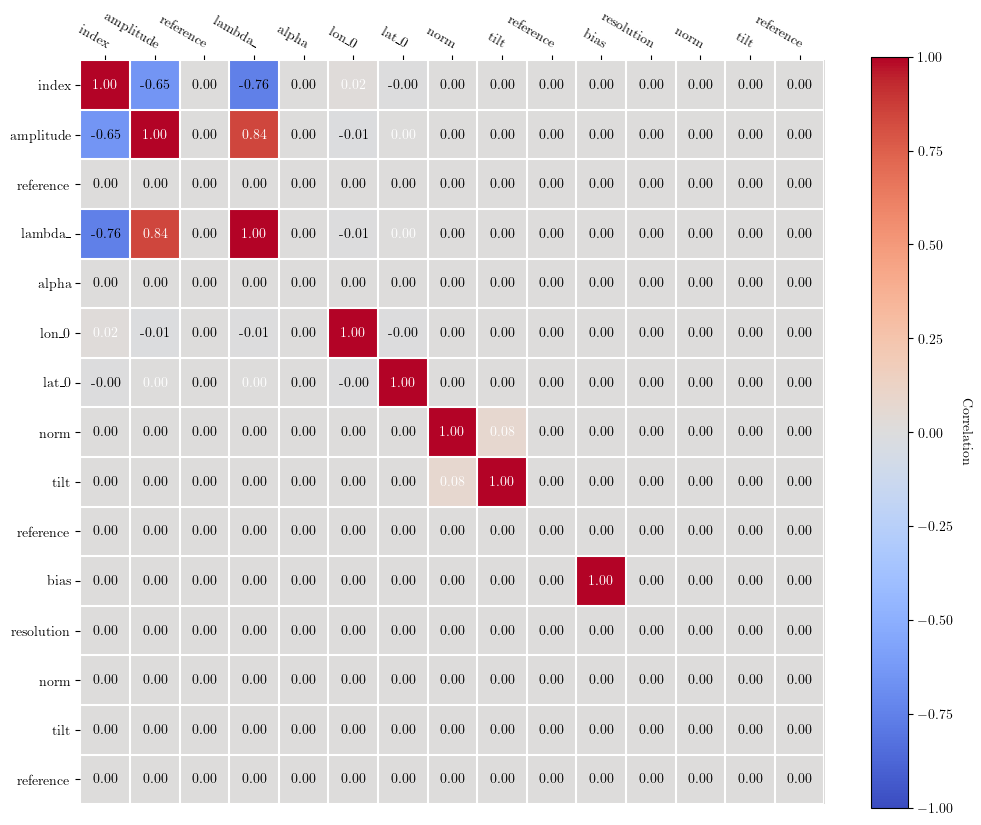

In [5]:
%%time
e_reco_n = 3000
if sys == "Eff_area":
    e_reco_n = 10
    
fitting_anyting = 1
if fitting_anyting :
    for i,l in enumerate(livetimes):
        datasets_i  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)

        dataset_asimov_N, dataset_asimov, setup = set_up(datasets_i)
        dataset_asimov_N.e_reco_n =e_reco_n

        fitting = 0
        if fitting:
            
            print(i, livetimes[i])
            fit_cor = Fit(store_trace=0)
            minuit_opts = {"tol": 0.1, "strategy": 2}
            fit_cor.backend = "minuit"
            fit_cor.optimize_opts = minuit_opts
            result_cor = fit_cor.run(dataset_asimov)
            print(result_cor)
            print(dataset_asimov.models)
            print("saving")
            path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
            dataset_asimov.models.write(path,overwrite=True)

        else:
            print(i)

        fitting_N = 1

        if fitting_N:
            if i == 7:
            
                print(i)
                fit_cor = Fit(store_trace=0)
                minuit_opts = {"tol": 0.1, "strategy": 2}
                fit_cor.backend = "minuit"
                fit_cor.optimize_opts = minuit_opts
                result_cor = fit_cor.run(dataset_asimov_N)
                print(result_cor)
                print(dataset_asimov_N.models)
                print("saving")
                path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}_{e_reco_n}.yml'
                dataset_asimov_N.models.write(path,overwrite=True)

                ax = dataset_asimov_N.models.covariance.plot_correlation()
                plt.savefig(f'../{folder}/plots/0_corr_nui_livetime_{livetimes[i]}_{e_reco_n}.pdf')
        else:
            print(livetimes[i])


else:
    datasets_i =  Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)